In [1]:
# Data commands:
# distractors: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweep vz3pljbi`
# non-stationary target: `python download_data.py --project=feature_recycling-rupam_distractors_task-hyper_search --sweeps 3gtd0r49`

In [2]:
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [3]:
save_path = 'figures/'
config_data_path = 'data/distractor_config_data.csv'
run_data_path = f'data/distractor_run_data.csv'

distractor_config_df = pd.read_csv(config_data_path, index_col=0)
distractor_config_df['run_id'] = distractor_config_df['id']
distractor_config_df = flatten_config_df(distractor_config_df)
distractor_run_df = pd.read_csv(run_data_path, index_col=0)

nst_data_path = 'data/non_stationary_target_config_data.csv'
nst_run_data_path = f'data/non_stationary_target_run_data.csv'

nst_config_df = pd.read_csv(nst_data_path, index_col=0)
nst_config_df['run_id'] = nst_config_df['id']
nst_config_df = flatten_config_df(nst_config_df)
nst_run_df = pd.read_csv(nst_run_data_path, index_col=0)

,name,id,sweep,idbd.version,idbd.autostep,idbd.meta_learning_rate,seed,task.name,task.type,task.n_layers,...,input_recycling.utility_decay,input_recycling.use_cbp_utility,input_recycling.distractor_chance,input_recycling.n_start_real_features,input_recycling.feature_protection_steps,feature_recycling.recycle_rate,feature_recycling.utility_decay,feature_recycling.use_cbp_utility,feature_recycling.feature_protection_steps,run_id
3,rosy-sweep-45,t0s4hxn7,vz3pljbi,squared_grads,True,0.005,3,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,t0s4hxn7
7,woven-sweep-41,qxfpecbs,vz3pljbi,squared_grads,True,0.005,2,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,qxfpecbs
11,hopeful-sweep-37,5aq3hvds,vz3pljbi,squared_grads,True,0.005,1,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,5aq3hvds
15,solar-sweep-33,g7wxsy3s,vz3pljbi,squared_grads,True,0.005,3,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,g7wxsy3s
19,jumping-sweep-29,jdp6fg4w,vz3pljbi,squared_grads,True,0.005,2,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,jdp6fg4w
23,winter-sweep-25,25zhqjug,vz3pljbi,squared_grads,True,0.005,1,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,25zhqjug
27,stellar-sweep-21,55et694n,vz3pljbi,squared_grads,True,0.005,3,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,55et694n
31,dry-sweep-17,lkh00eak,vz3pljbi,squared_grads,True,0.005,2,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,lkh00eak
35,smart-sweep-13,pvd5zsvj,vz3pljbi,squared_grads,True,0.005,1,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,pvd5zsvj
39,exalted-sweep-9,yggkxscl,vz3pljbi,squared_grads,True,0.005,3,nonlinear_geoff,regression,2,...,0.99,False,0,-1,100,0.005,0.99,True,0,yggkxscl


## Distractor Count Ablation

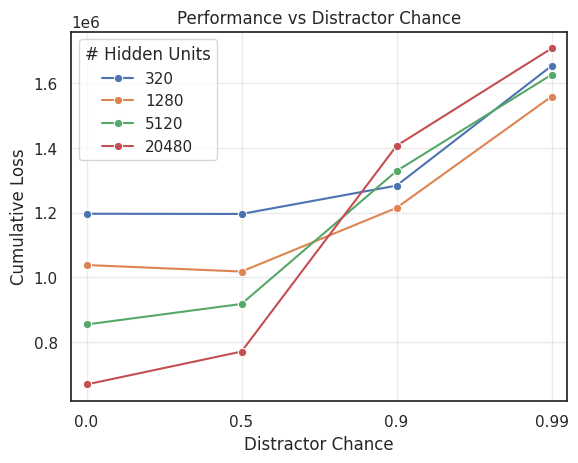

In [4]:
final_step_df = distractor_run_df.sort_values('step').groupby('run_id').last().reset_index()
final_step_df = final_step_df.merge(distractor_config_df, on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_step_df['task.distractor_chance'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_step_df['x_position'] = final_step_df['task.distractor_chance'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_step_df,
    x = 'x_position',
    y = 'cumulative_loss', 
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4)  # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
plt.xticks(x_positions, x_values)  # Use original values as labels
plt.title('Performance vs Distractor Chance')
plt.xlabel('Distractor Chance')
plt.ylabel('Cumulative Loss')
plt.legend(title='# Hidden Units')

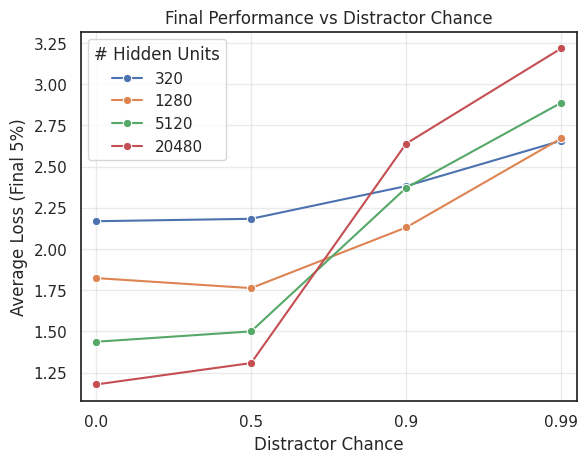

In [5]:
# Get the last 5% of steps for each run
max_steps_per_run = distractor_run_df.groupby('run_id')['step'].max()
threshold_steps = max_steps_per_run * 0.95

# Filter for last 5% of steps and calculate mean loss
final_loss_df = distractor_run_df.merge(
    threshold_steps.rename('threshold_step'),
    left_on='run_id',
    right_index=True
)
final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
final_loss_df = final_loss_df.groupby('run_id')['loss'].mean().reset_index()

# Merge with config data
final_loss_df = final_loss_df.merge(distractor_config_df, on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_loss_df['task.distractor_chance'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_loss_df['x_position'] = final_loss_df['task.distractor_chance'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_loss_df,
    x = 'x_position',
    y = 'loss',
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4)  # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
plt.xticks(x_positions, x_values)  # Use original values as labels
plt.title('Final Performance vs Distractor Chance')
plt.xlabel('Distractor Chance')
plt.ylabel('Average Loss (Final 5%)')
plt.legend(title='# Hidden Units')

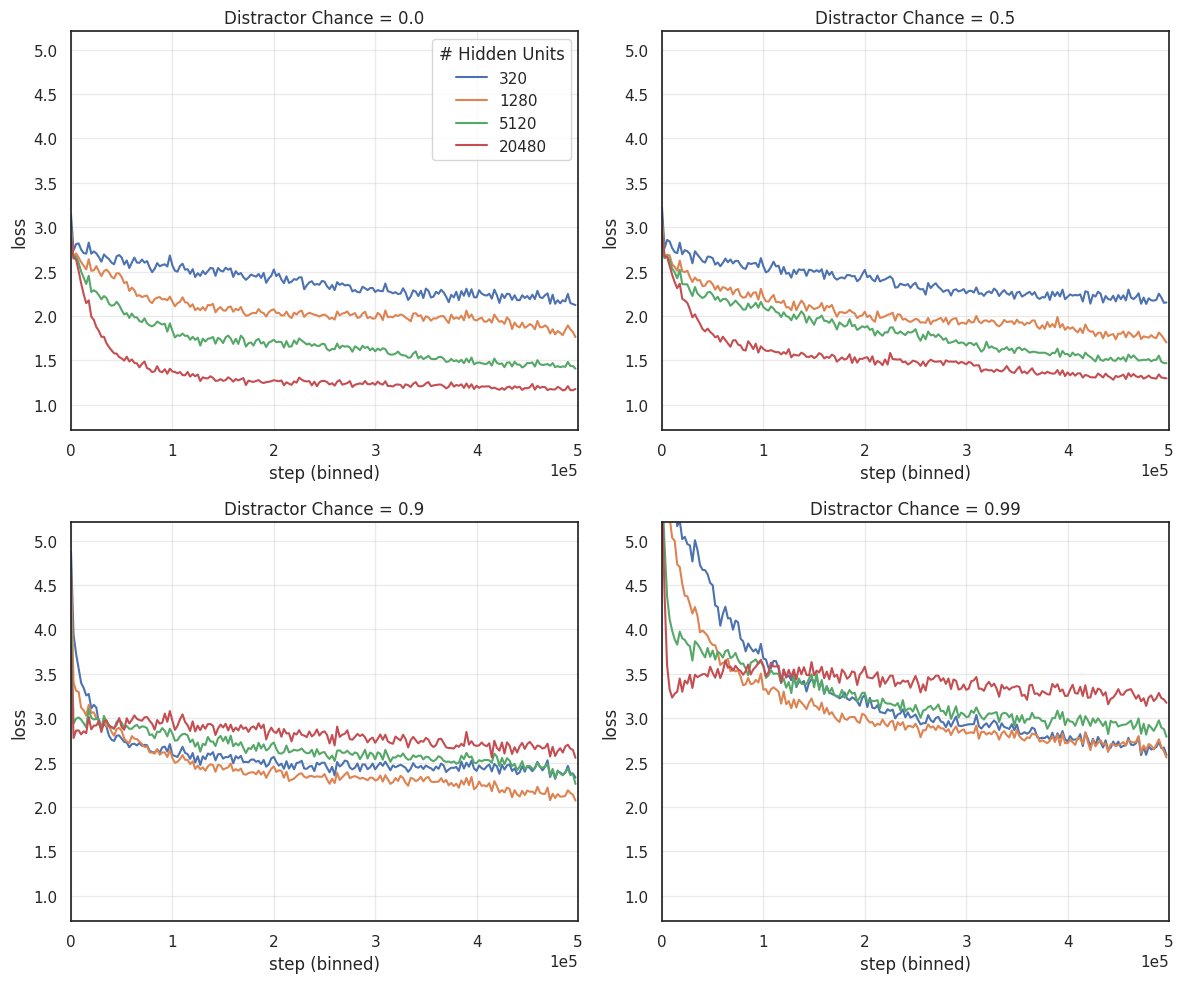

In [6]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

distractor_chances = [0.0, 0.5, 0.9, 0.99]

# Get full dataset
plot_df = distractor_run_df.merge(distractor_config_df, on='run_id', how='left')

# Calculate mid 98% percentile for consistent y-axis
filtered_df = plot_df[
    (plot_df['loss'] >= np.percentile(plot_df['loss'], 1)) &
    (plot_df['loss'] <= np.percentile(plot_df['loss'], 99))
]
y_range = filtered_df['loss'].max() - filtered_df['loss'].min()
y_pad = y_range * 0.1
y_min = filtered_df['loss'].min() - y_pad
y_max = filtered_df['loss'].max() + y_pad

for i, dc in enumerate(distractor_chances):
    # Filter for current distractor chance
    curr_df = plot_df[plot_df['task.distractor_chance'] == dc].copy()
    
    # Bin data
    curr_df = bin_df(curr_df, n_bins=200)
    curr_df = curr_df[curr_df['model.hidden_dim'].notna()]  # Remove NaN values
    curr_df['model.hidden_dim'] = curr_df['model.hidden_dim'].astype(int)
    
    # Create subplot
    sns.lineplot(
        data = curr_df,
        x = 'step',
        y = 'loss',
        hue = 'model.hidden_dim', 
        palette = 'deep',
        errorbar = None,
        ax = axes[i]
    )
    
    # Customize subplot
    axes[i].grid(True, alpha=0.4)
    axes[i].set_xlim(0, 500_000)
    axes[i].set_ylim(y_min, y_max)
    axes[i].set_title(f'Distractor Chance = {dc}')
    axes[i].set_xlabel('step (binned)')
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[i].set_ylabel('loss')
    
    # Only show legend on first subplot
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(title='# Hidden Units')

plt.tight_layout()

## Target Non-Stationarity Ablation

In [14]:
# Correct flip_rate column
if nst_config_df['task.flip_rate'].dtype == 'object':
    nst_config_df['task.flip_rate'] = nst_config_df['task.flip_rate'].apply(
        lambda x: eval(re.match(r'\${eval:(.*)}', x).group(1)))

In [ ]:
no_distractor_conf = distractor_config_df[distractor_config_df['task.distractor_chance'] == 0]
no_distractor_runs = distractor_run_df[distractor_run_df['task.distractor_chance'] == 0]

augmented_nst_config_df = pd.concat([no_distractor_conf, nst_config_df])
augmented_nst_run_df = pd.concat([no_distractor_runs, nst_run_df])


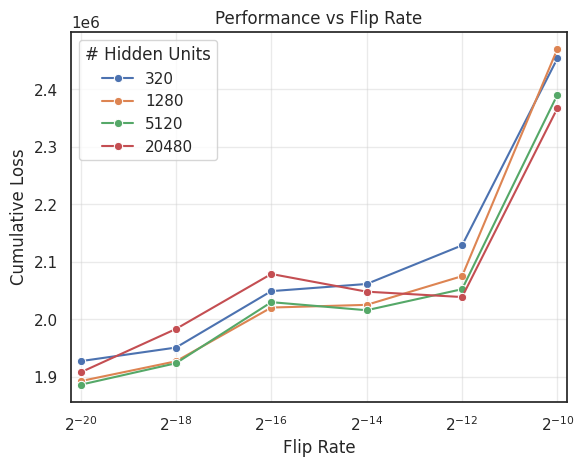

In [17]:
final_step_df = nst_run_df.sort_values('step').groupby('run_id').last().reset_index()
final_step_df = final_step_df.merge(nst_config_df, on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_step_df['task.flip_rate'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_step_df['x_position'] = final_step_df['task.flip_rate'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_step_df,
    x = 'x_position',
    y = 'cumulative_loss', 
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4) # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9) # Add small padding on both sides
plt.xticks(x_positions, [f'$2^{{{int(np.log2(x))}}}$' for x in x_values])
plt.title('Performance vs Flip Rate')
plt.xlabel('Flip Rate')
plt.ylabel('Cumulative Loss')
plt.legend(title='# Hidden Units')

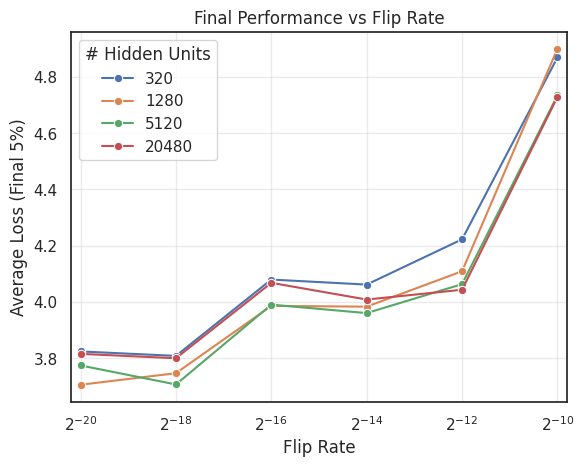

In [18]:
# Get the last 5% of steps for each run
max_steps_per_run = nst_run_df.groupby('run_id')['step'].max()
threshold_steps = max_steps_per_run * 0.95

# Filter for last 5% of steps and calculate mean loss
final_loss_df = nst_run_df.merge(
    threshold_steps.rename('threshold_step'),
    left_on='run_id',
    right_index=True
)
final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
final_loss_df = final_loss_df.groupby('run_id')['loss'].mean().reset_index()

# Merge with config data
final_loss_df = final_loss_df.merge(nst_config_df, on='run_id', how='left')

# Create a mapping of actual values to evenly spaced positions
x_values = sorted(final_loss_df['task.flip_rate'].unique())
x_positions = np.arange(len(x_values))
x_map = dict(zip(x_values, x_positions))

# Create temporary column with evenly spaced x positions
final_loss_df['x_position'] = final_loss_df['task.flip_rate'].map(x_map)

# Create plot with evenly spaced x positions
sns.lineplot(
    data = final_loss_df,
    x = 'x_position',
    y = 'loss',
    hue = 'model.hidden_dim',
    marker = 'o',
    palette = 'deep',
    errorbar = None,
)

# Customize plot
plt.grid(True, alpha=0.4)  # Add light grid
plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
plt.xticks(x_positions, [f'$2^{{{int(np.log2(x))}}}$' for x in x_values])
plt.title('Final Performance vs Flip Rate')
plt.xlabel('Flip Rate')
plt.ylabel('Average Loss (Final 5%)')
plt.legend(title='# Hidden Units')